<a href="https://colab.research.google.com/github/wandiab/PINNs_BuckleyLeverett/blob/main/BuckleyLeverett_Attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
# Installing Packages 
!sudo apt-get install dvipng texlive-latex-extra texlive-fonts-recommended 
!sudo apt-get install dvipng texlive-latex-extra texlive-fonts-recommended cm-super 
!pip install pyDOE

Reading package lists... Done
Building dependency tree       
Reading state information... Done
dvipng is already the newest version (1.15-1).
texlive-fonts-recommended is already the newest version (2017.20180305-1).
texlive-latex-extra is already the newest version (2017.20180305-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
cm-super is already the newest version (0.3.4-11).
dvipng is already the newest version (1.15-1).
texlive-fonts-recommended is already the newest version (2017.20180305-1).
texlive-latex-extra is already the newest version (2017.20180305-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 

In [ ]:
# Imports
import sys
import json
import os
import tensorflow as tf
import numpy as np
import tensorflow.experimental.numpy as tnp
import tensorflow_probability as tfp
import scipy
from scipy import io
import random
import scipy.io
import time
from datetime import datetime
from pyDOE import lhs
import os
import sys
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from scipy.interpolate import griddata
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl

# Manually making sure the numpy random seeds are "the same" on all devices
random.seed(1234)
np.random.seed(1234)
tf.random.set_seed(1234)

Plotting and Logger

In [ ]:
mpl.use('pgf')

def figsize(scale, nplots = 1):
    fig_width_pt = 690.0                          # Get this from LaTeX using \the\textwidth
    inches_per_pt = 1.0/72.27                       # Convert pt to inch
    golden_mean = (np.sqrt(5.0)-1.0)/2.0            # Aesthetic ratio (you could change this)
    fig_width = fig_width_pt*inches_per_pt*scale    # width in inches
    fig_height = nplots*fig_width*golden_mean              # height in inches
    fig_size = [fig_width,fig_height]
    return fig_size

pgf_with_latex = {                      # setup matplotlib to use latex for output
    "pgf.texsystem": "pdflatex",        # change this if using xetex or lautex
    "text.usetex": True,                # use LaTeX to write all text
    "font.family": "serif",
    "font.serif": [],                   # blank entries should cause plots to inherit fonts from the document
    "font.sans-serif": [],
    "font.monospace": [],
    "axes.labelsize": 8,               # LaTeX default is 10pt font.
    "font.size": 8,
    "legend.fontsize": 8,               # Make the legend/label fonts a little smaller
    "xtick.labelsize": 6,
    "ytick.labelsize": 6,
    "figure.figsize": figsize(1.0),     # default fig size of 0.9 textwidth
    "pgf.preamble": [
        r"\usepackage[utf8x]{inputenc}",    # use utf8 fonts becasue your computer can handle it :)
        r"\usepackage[T1]{fontenc}",        # plots will be generated using this preamble
        ]
    }
mpl.rcParams.update(pgf_with_latex)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# I make my own newfig and savefig functions
def newfig(width, nplots = 1):
    fig = plt.figure(figsize=figsize(width, nplots), dpi=300)
    ax = fig.add_subplot(111)
    return fig, ax

def plot_inf_cont_results(X_star, u_pred, X_u_train, u_train, Exact_u, X, T, x, t):

  # Interpolating the results on the whole (x,t) domain.
  # griddata(points, values, points at which to interpolate, method)
  U_pred = griddata(X_star, u_pred, (X, T), method='cubic')

  # Creating the figures
  fig, ax = newfig(1.0, 1.1)
  ax.axis('off')

  ####### Row 0: u(t,x) ##################    
  gs0 = gridspec.GridSpec(1, 2)
  gs0.update(top=1-0.06, bottom=1-1/3, left=0.15, right=0.85, wspace=0)
  ax = plt.subplot(gs0[:, :])

  h = ax.imshow(U_pred.T, interpolation='nearest', cmap='viridis', 
                extent=[t.min(), t.max(), x.min(), x.max()], 
                origin='lower', aspect='auto')
  divider = make_axes_locatable(ax)
  cax = divider.append_axes("right", size="5%", pad=0.05)
  fig.colorbar(h, cax=cax)

  ax.plot(X_u_train[:,1], X_u_train[:,0], 'kx', label = 'Data (%d points)' % (u_train.shape[0]), markersize = 4, clip_on = False)

  line = np.linspace(x.min(), x.max(), 2)[:,None]
  ax.plot(t[10]*np.ones((2,1)), line, 'r--', linewidth = 1)
  ax.plot(t[25]*np.ones((2,1)), line, 'r--', linewidth = 1)
  ax.plot(t[40]*np.ones((2,1)), line, 'r--', linewidth = 1)
  ax.plot(t[55]*np.ones((2,1)), line, 'r--', linewidth = 1)
  ax.plot(t[70]*np.ones((2,1)), line, 'r--', linewidth = 1)
  ax.plot(t[90]*np.ones((2,1)), line, 'r--', linewidth = 1)    

  ax.set_xlabel('$t$')
  ax.set_ylabel('$x$')
  ax.legend(frameon=False, loc = 'best')
  ax.set_title('$u(t,x)$', fontsize = 5)

  ####### Row 1: u(t,x) slices ##################    
  gs1 = gridspec.GridSpec(2, 5)
  gs1.update(top=1-1/4, bottom=0.2, left=0.1, right=0.9, wspace=0.5)

  ax = plt.subplot(gs1[0, 0])
  ax.plot(x,Exact_u[10,:], color='blue', linewidth = 1.5, label = 'Exact')       
  ax.plot(x,U_pred[10,:], 'r--', linewidth = 1.5, label = 'Prediction')
  ax.set_xlabel('$x$')
  ax.set_ylabel('$u(t,x)$')    
  ax.set_title('$t = 0.10$', fontsize = 7)
  ax.axis('square')
  ax.set_xlim([-0.1,1.1])
  ax.set_ylim([-0.1,1.1])

  ax = plt.subplot(gs1[0, 1])
  ax.plot(x,Exact_u[25,:], color='blue', linewidth = 1.5, label = 'Exact')       
  ax.plot(x,U_pred[25,:], 'r--', linewidth = 1.5, label = 'Prediction')  
  ax.set_title('$t = 0.25$', fontsize = 7)
  ax.axis('square')
  ax.set_xlim([-0.1,1.1])
  ax.set_ylim([-0.1,1.1])

  ax = plt.subplot(gs1[0, 2])
  ax.plot(x,Exact_u[40,:], color='blue', linewidth = 1.5, label = 'Exact')       
  ax.plot(x,U_pred[40,:], 'r--', linewidth = 1.5, label = 'Prediction')  
  ax.set_title('$t = 0.40$', fontsize = 7)
  ax.axis('square')
  ax.set_xlim([-0.1,1.1])
  ax.set_ylim([-0.1,1.1])

  ax = plt.subplot(gs1[1, 0])
  ax.plot(x,Exact_u[55,:], color='blue', linewidth = 1.5, label = 'Exact')       
  ax.plot(x,U_pred[55,:], 'r--', linewidth = 1.5, label = 'Prediction')
  ax.set_xlabel('$x$')
  ax.set_ylabel('$u(t,x)$')
  ax.axis('square')
  ax.set_xlim([-0.1,1.1])
  ax.set_ylim([-0.1,1.1])
  ax.set_title('$t = 0.55$', fontsize = 7)
  ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.35), ncol=5, frameon=False)

  ax = plt.subplot(gs1[1, 1])
  ax.plot(x,Exact_u[70,:], color='blue', linewidth = 1.5, label = 'Exact')       
  ax.plot(x,U_pred[70,:], 'r--', linewidth = 1.5, label = 'Prediction')   
  ax.set_title('$t = 0.70$', fontsize = 7)
  ax.axis('square')
  ax.set_xlim([-0.1,1.1])
  ax.set_ylim([-0.1,1.1])

  ax = plt.subplot(gs1[1, 2])
  ax.plot(x,Exact_u[90,:], color='blue', linewidth = 1.5, label = 'Exact')       
  ax.plot(x,U_pred[90,:], 'r--', linewidth = 1.5, label = 'Prediction')
  ax.axis('square')
  ax.set_xlim([-0.1,1.1])
  ax.set_ylim([-0.1,1.1])    
  ax.set_title('$t = 0.90$', fontsize = 7)

  plt.show();

class Logger(object):
  def __init__(self, frequency=20):
    print("TensorFlow version: {}".format(tf.__version__))
    print("Eager execution: {}".format(tf.executing_eagerly()))
    print("GPU-accerelated: {}".format(tf.test.is_gpu_available()))

    self.start_time = time.time()
    self.frequency = frequency

  def __get_elapsed(self):
    return datetime.fromtimestamp(time.time() - self.start_time).strftime("%M:%S")

  def __get_error_u(self):
    return self.error_fn()

  def set_error_fn(self, error_fn):
    self.error_fn = error_fn
  
  def log_train_start(self, model):
    print("\nTraining started")
    print("================")

  def log_train_epoch(self, epoch, loss, custom="", is_iter=False):
    if epoch % self.frequency == 0:
      print(f"{'nt_epoch' if is_iter else 'tf_epoch'} = {epoch:6d}  elapsed = {self.__get_elapsed()}  loss = {loss:.4e} " + custom)

  def log_train_opt(self, name):
    print(f"—— Starting {name} optimization ——")

  def log_train_end(self, epoch, custom=""):
    print("==================")
    print(f"Training finished (epoch {epoch}): duration = {self.__get_elapsed()}  error = {self.__get_error_u():.4e}  " + custom)

# Prep Data

In [ ]:
def prep_data(path, N_u=None, N_f=None):
    # Reading external data [t is 100x1, usol is 256x100 (solution), x is 256x1]
    #data = scipy.io.loadmat(path)
    data = path
    # Flatten makes [[]] into [], [:,None] makes it a column vector
    t = data['t'].flatten()[:,None] # T x 1
    x = data['x'].flatten()[:,None] # N x 1

    # Keeping the 2D data for the solution data (real() is maybe to make it float by default, in case of zeroes)
    Exact_u = np.real(data['usol']).T # T x N

    # Meshing x and t in 2D (256,100)
    X, T = np.meshgrid(x,t)

    # Preparing the inputs x and t (meshed as X, T) for predictions in one single array, as X_star
    X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))

    # Preparing the testing u_star
    u_star = Exact_u.flatten()[:,None]
                
    # Noiseless data TODO: add support for noisy data    
    idx = np.random.choice(X_star.shape[0], N_u, replace=False)
    X_u_train = X_star[idx,:]
    u_train = u_star[idx,:]

    # Domain bounds (lowerbounds upperbounds) [x, t], which are here ([0.0, 0.0] and [1.0, 1.0])
    lb = X_star.min(axis=0)
    ub = X_star.max(axis=0) 
    # Getting the initial conditions (t=0)
    xx1 = np.hstack((X[0:1,:].T, T[0:1,:].T))
    uu1 = Exact_u[0:1,:].T
    # Getting the lowest boundary conditions (x=0) 
    xx2 = np.hstack((X[:,0:1], T[:,0:1]))
    uu2 = Exact_u[:,0:1]

    # Stacking them in multidimensional tensors for training (X_u_train is for now the continuous boundaries)
    X_u_train = np.vstack([xx1, xx2])
    u_train = np.vstack([uu1, uu2])

    # Generating the x and t collocation points for f, with each having a N_f size
    # We pointwise add and multiply to spread the LHS over the 2D domain
    X_f_train = lb + (ub-lb)*lhs(2, N_f)

    # Generating a uniform random sample from ints between 0, and the size of x_u_train, of size N_u (initial data size) and without replacement (unique)
    idx = np.random.choice(X_u_train.shape[0], N_u, replace=False)
    # Getting the corresponding X_u_train (which is now scarce boundary/initial coordinates)
    X_u_train = X_u_train[idx,:]
    # Getting the corresponding u_train
    u_train = u_train [idx,:]

    return x, t, X, T, Exact_u, X_star, u_star, X_u_train, u_train, X_f_train, ub, lb

# HYPER PARAMETERS

In [ ]:
# Data size on the solution u
N_u = 300
# Collocation points size, where we’ll check for f = 0
N_f = 2000
# DeepNN topology (2-sized input [x t], 8 hidden layer of 20-width, 1-sized output [u]
layers = [2, 20, 20, 20, 20, 20, 20, 1]
# Setting up the TF SGD-based optimizer (set tf_epochs=0 to cancel it)
tf_epochs = 50000

initial_learning_rate = 1e-3
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,
    decay_rate=0.96,
    staircase=False)

tf_optimizer = tf.keras.optimizers.Adam(
  learning_rate= lr_schedule,
  beta_1=0.96,
  epsilon=1e-7)

# Physics Informed NN

In [ ]:
# This Code Does NOT Run in graph mode therefore it is significantly slower than the MLP
class PhysicsInformedNN(object):
  def __init__(self, layers, optimizer, logger, X_f, ub, lb):

    self.weights, self.biases = self.initialize_NN(layers)
    
    # Initialize encoder weights and biases
    self.encoder_weights_1 = self.xavier_init([2, layers[1]])  
    self.encoder_biases_1 = self.xavier_init([1, layers[1]])

    self.encoder_weights_2 = self.xavier_init([2, layers[1]])
    self.encoder_biases_2 = self.xavier_init([1, layers[1]])

    self.optimizer = optimizer
    self.logger = logger
    self.layers = layers
    self.dtype = tf.float32

    # Separating the collocation coordinates
    self.x_f = tf.convert_to_tensor(X_f[:, 0:1], dtype=self.dtype)
    self.t_f = tf.convert_to_tensor(X_f[:, 1:2], dtype=self.dtype)
    
  # Defining custom loss
  @tf.function
  def loss(self, u, u_pred):
    f_pred, weight_resd1 = self.f_model()
    return tf.reduce_mean(tf.square(u - u_pred)) + tf.reduce_mean(tf.square(f_pred))

  @tf.function
  def grad(self, X, u):
    with tf.GradientTape() as tape:
      loss_value = self.loss(u, self.forward_pass(X))
    return loss_value, tape.gradient(loss_value, self.get_weights())

  # Xavier initialization
  def xavier_init(self, size):
    in_dim = size[0]
    out_dim = size[1]
    xavier_stddev = 1. / np.sqrt((in_dim + out_dim) / 2.)
    return tf.Variable(tf.random.normal([in_dim, out_dim], dtype=tf.float32) * xavier_stddev,
                       dtype=tf.float32)
    
  # Initialize S network weights and biases using Xavier initialization
  def initialize_NN(self, layers):
    weights = []
    biases = []
    num_layers = len(layers)
    for l in range(0, num_layers - 1):
      W = self.xavier_init(size=[layers[l], layers[l + 1]])
      b = tf.Variable(tf.zeros([1, layers[l + 1]], dtype=tf.float32), dtype=tf.float32)
      weights.append(W)
      biases.append(b)
    return weights, biases
  
  def H(x):
    return tf.divide(1.0, (tf.add(1.0, tf.exp(-2.0*30.0*x))))

  # Evaluates the forward pass.
  @tf.function
  def forward_pass(self, H):
    H = 1.0*(H - lb)/(ub - lb) - 0.0
    num_layers = len(self.layers)
    encoder_1 = tf.tanh(tf.add(tf.matmul(H, self.encoder_weights_1), self.encoder_biases_1))
    encoder_2 = tf.tanh(tf.add(tf.matmul(H, self.encoder_weights_2), self.encoder_biases_2))
    for l in range(0, num_layers - 2):
      W = self.weights[l]
      b = self.biases[l]
      H = tf.math.multiply(tf.tanh(tf.add(tf.matmul(H, W), b)), encoder_1) + \
      tf.math.multiply(tf.tanh(tf.add(1 - tf.matmul(H, W), b)), encoder_2)
    W = self.weights[-1]
    b = self.biases[-1]
    H = tf.add(tf.matmul(H, W), b)
    return H

  # The actual PINN
  @tf.function
  def f_model(self):
    #here u is the S (saturation function)
    with tf.GradientTape(persistent=True) as tape:
      tape.watch(self.x_f)
      tape.watch(self.t_f)
      X_f = tf.stack([self.x_f[:,0], self.t_f[:,0]], axis=1)
      u = self.forward_pass(X_f)

      Swc = 0.0
      M = 2
      Sor = 0.0

      #Non-Convex Flux Function
      frac_org = tf.divide(tf.square(u-Swc), tf.square(u-Swc) + tf.divide(tf.square(1 - u - Sor), M))
      Sf = tf.sqrt(tf.divide(1/M, (1/M)+1))
      frac_Sf = tf.divide(tf.square(Sf-Swc), tf.square(Sf-Swc) + tf.divide(tf.square(1 - Sf - Sor), M))
      frac = tf.divide(frac_Sf, Sf)*u - tf.multiply(tf.divide(frac_Sf, Sf)*u, tnp.heaviside(u-Sf, 1)) + tf.multiply(frac_org, tnp.heaviside(u-Sf, 1))

    u_x = tape.gradient(u, self.x_f)
    u_t = tape.gradient(u, self.t_f)
    frac_u = tape.gradient(frac, u)
    weight_resd = tf.divide(1, (tf.square(u_t) + tf.square(u_x) + 1)) 

    del tape 
    return u_t + frac_u * u_x, weight_resd

  def get_weights(self):
    w = []
    for i in range(len(self.weights)):
      W = self.weights[i]
      b = self.biases[i]
      w.append(W)
      w.append(b)
    return w

  # The training function
  def fit(self, X_u, u, tf_epochs):
    self.logger.log_train_start(self)

    # Creating the tensors
    X_u = tf.convert_to_tensor(X_u, dtype=self.dtype)
    u = tf.convert_to_tensor(u, dtype=self.dtype)

    self.logger.log_train_opt("Adam")
    for epoch in range(tf_epochs):
      # Optimization step
      loss_value, grads = self.grad(X_u, u)
      self.optimizer.apply_gradients(zip(grads, self.get_weights()))
      self.logger.log_train_epoch(epoch, loss_value)
    
    self.logger.log_train_end(tf_epochs + 1)

  def predict(self, X_star):
    X_star_tf = tf.convert_to_tensor(X_star, dtype=self.dtype)
    u_star = self.forward_pass(X_star_tf)
    return u_star


# Training

In [ ]:
# Getting the data
path = scipy.io.loadmat('/content/drive/MyDrive/GoogleColab-PINN/PINNs-TF2.0-Waleed/1d-Buckley/data/Buckley_Swc_0_Sor_0_M_2.mat');
x, t, X, T, Exact_u, X_star, u_star, X_u_train, u_train, X_f, ub, lb = prep_data(path, N_u, N_f)

# Creating the model and training
logger = Logger(frequency=200)
pinn = PhysicsInformedNN(layers, tf_optimizer, logger, X_f, ub, lb)
def error():
  u_pred = pinn.predict(X_star)
  return np.linalg.norm(u_star - u_pred) / np.linalg.norm(u_star)
logger.set_error_fn(error)

# This Code Does NOT Run in graph mode therefore it is significantly slower than the MLP
pinn.fit(X_u_train, u_train, tf_epochs)

# Getting the model predictions, from the same (x,t) that the predictions were previously gotten from
u_pred = pinn.predict(X_star)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


TensorFlow version: 2.8.2
Eager execution: True
GPU-accerelated: True

Training started
—— Starting Adam optimization ——
tf_epoch =      0  elapsed = 00:04  loss = 2.4439e-01 
tf_epoch =    200  elapsed = 00:07  loss = 5.9487e-02 
tf_epoch =    400  elapsed = 00:09  loss = 4.3450e-02 
tf_epoch =    600  elapsed = 00:12  loss = 1.8591e-02 
tf_epoch =    800  elapsed = 00:14  loss = 1.2012e-02 
tf_epoch =   1000  elapsed = 00:16  loss = 8.4032e-03 
tf_epoch =   1200  elapsed = 00:18  loss = 7.2160e-03 
tf_epoch =   1400  elapsed = 00:20  loss = 6.4736e-03 
tf_epoch =   1600  elapsed = 00:22  loss = 5.7327e-03 
tf_epoch =   1800  elapsed = 00:24  loss = 4.8796e-03 
tf_epoch =   2000  elapsed = 00:26  loss = 4.4010e-03 
tf_epoch =   2200  elapsed = 00:28  loss = 4.1673e-03 
tf_epoch =   2400  elapsed = 00:30  loss = 3.9097e-03 
tf_epoch =   2600  elapsed = 00:32  loss = 3.6092e-03 
tf_epoch =   2800  elapsed = 00:34  loss = 3.2993e-03 
tf_epoch =   3000  elapsed = 00:37  loss = 3.0423e-03 

# Plotting

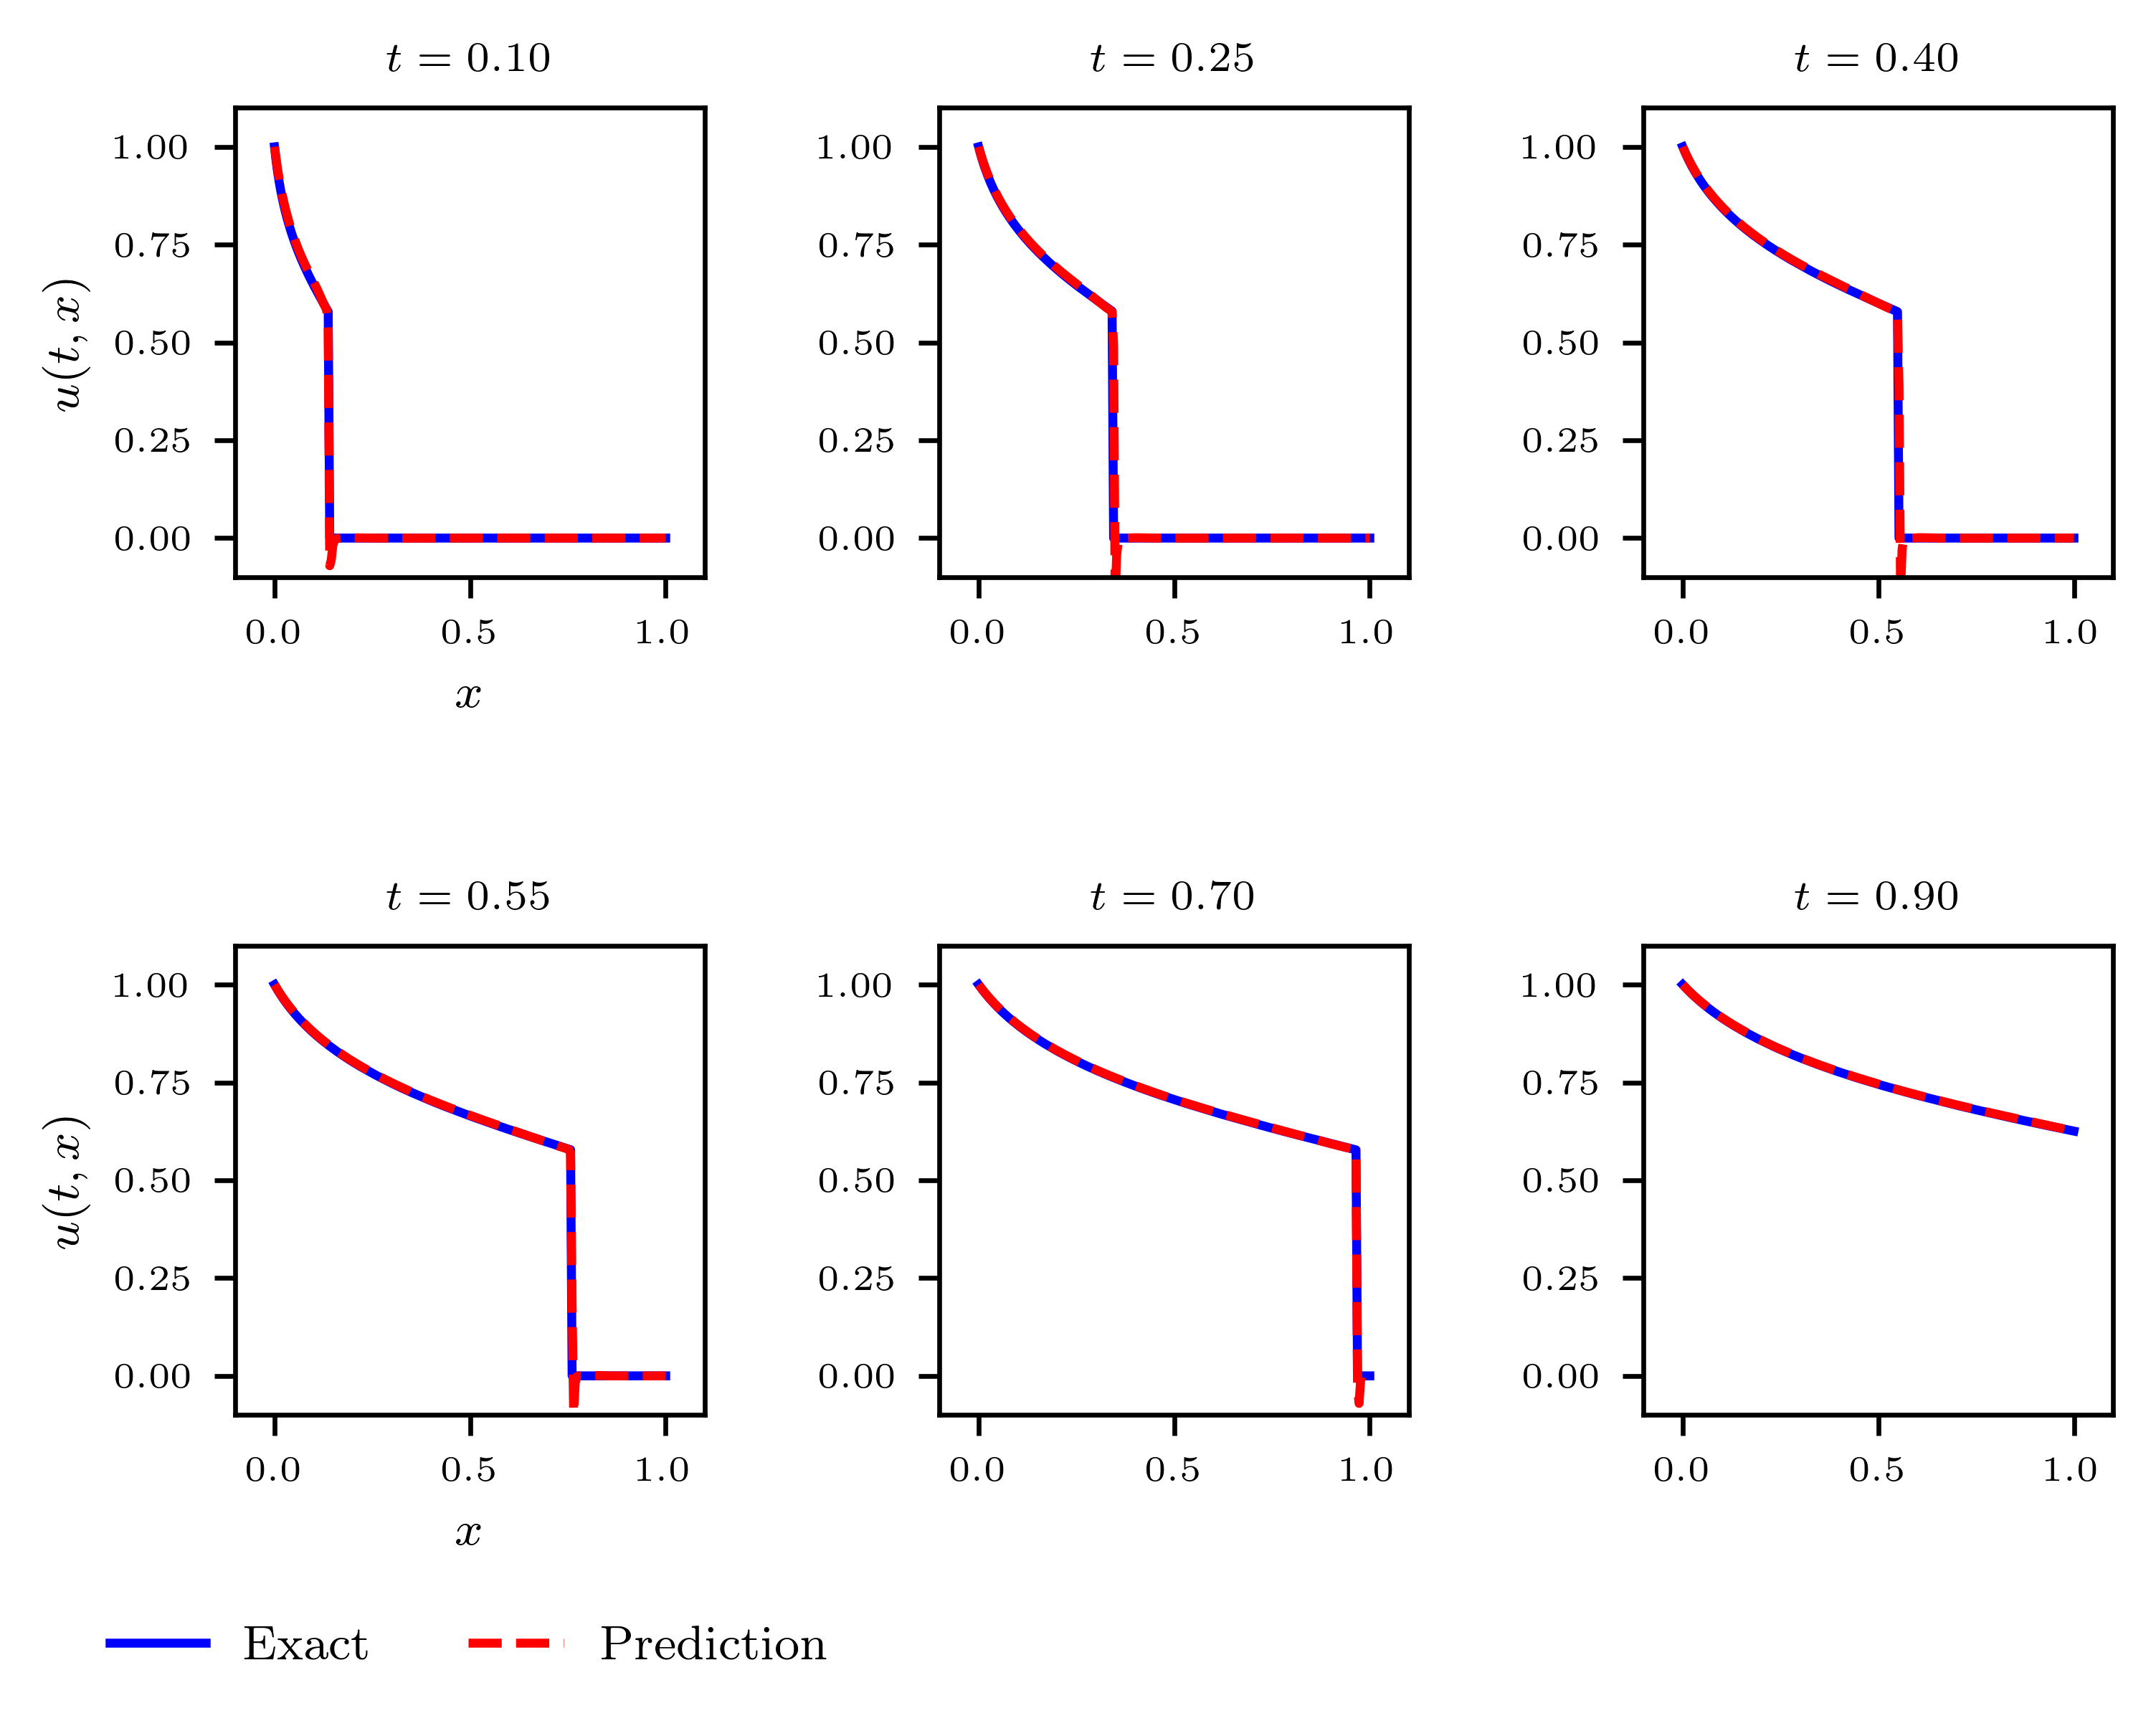

In [ ]:
plot_inf_cont_results(X_star, u_pred.numpy().flatten(), X_u_train, u_train, Exact_u, X, T, x, t)